In [1]:
#imports
import numpy as np
from skimage.measure import label, regionprops
from skimage.draw import line, set_color
import imageio
import cv2
import operator
import math
import matplotlib.pyplot as plt
%matplotlib inline 
import time
from tqdm import tqdm_notebook
from PIL import Image
import argparse
# from Tkinter import *

In [2]:
#Find homography
source_pts = np.array([[100, 90], [475, 70], [425, 370], [75, 470]], dtype = 'float32') #pixels!
dst_pts = np.array([[0, 0], [100, 0], [80, 80], [0, 100]], dtype = 'float32') #cm

homography_matrix, _ = cv2.findHomography(source_pts, dst_pts, cv2.RANSAC, 5.0) #not sure what the 5.0 is really doing seems to work though
POINTMOO = np.array([[75,470]],dtype = 'float32')
POINTMOO = np.array([POINTMOO])
dst_pt = cv2.perspectiveTransform(POINTMOO, homography_matrix)
#print(dst_pt[0][0][0])
#print(dst_pt[0][0][1])
#print(dst_pt)

In [3]:
#Locations of objects and distance thresholds (how close does the rat have to be to be near it)
familiarObject_center_x = 380
familiarObject_center_y = 160
realWorld_famObj_center = cv2.perspectiveTransform(np.array([np.array([[familiarObject_center_x,familiarObject_center_y]], dtype='float32')]), homography_matrix)
familiarObject_center_x_realWorld = realWorld_famObj_center[0][0][0]
familiarObject_center_y_realWorld = realWorld_famObj_center[0][0][1]
DistanceThreshold_familiarObject = 22;
numFrames_FamiliarObject = 0;

novelObject_center_x = 210
novelObject_center_y = 320
realWorld_novelObj_center = cv2.perspectiveTransform(np.array([np.array([[novelObject_center_x,novelObject_center_y]],dtype='float32')]), homography_matrix)
novelObject_center_x_realWorld = realWorld_novelObj_center[0][0][0]
novelObject_center_y_realWorld = realWorld_novelObj_center[0][0][1]
DistanceThrehshold_NovelObject = 22;
numFrames_NovelObject = 0;

In [4]:
#setup for background model and foreground tracking
if 'fgbg' not in locals():
    fgbg = cv2.createBackgroundSubtractorKNN()
    
morph_size = 2
shadowValue = 127
learnBG = False
showShadow = False

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(morph_size,morph_size))

# Actual Work Happens Below

input video file length is 697.2333333333333 seconds
input video file has a framerate of 30.0 fps
241 405
hi I'm iin here
281 429
hi I'm iin here
258 428
hi I'm iin here
187 349
hi I'm iin here
Total amount of time spent with objects: 1.7333333333333334 seconds
Percentage of time spent with objects that was spent with the novel object: 100.0%
exited gracefully


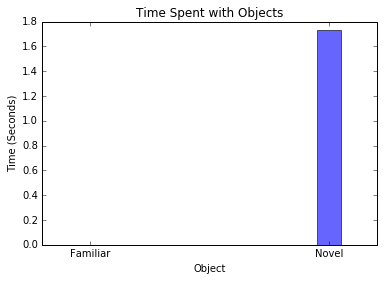

In [28]:
#File IO
numFrames_FamiliarObject = 0
numFrames_NovelObject = 0
reader = imageio.get_reader('Round2/Day3/Test-2-cropped.mkv')
fps = reader.get_meta_data()['fps']
print('input video file length is {} seconds'.format(reader.get_length()/(fps)))
print('input video file has a framerate of {} fps'.format(fps))
writer = imageio.get_writer('test-out.mp4', fps=fps)

# def click(event, x, y, flags, param):
#     # grab references to the global variables
#     global refPt
    
#     # if the left mouse button was clicked, record the starting
#     # (x, y) coordinates and indicate that cropping is being
#     # performed
#     if event == cv2.EVENT_LBUTTONDOWN:
#         refPt = [(x, y)]
#         posx = refPt[0]
#         posy = refPt[1]
#         return posx, posy

# click(cv2.EVENT_LBUTTONDOWN)

class Position:
    def __init__(self, m, n):
        self.coordinates = np.zeros((m, n))
        self.click = False

    def select_coordinates(self, event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            #Set coordinates to mouse position
            self.coordinates[i, :] = [x, y]
            self.clickcoords = [x,y]
            print (self.clickcoords[0], self.clickcoords[1])
            self.click = True
position = Position(reader.get_length(), 2)
cv2.namedWindow('im', flags=cv2.WINDOW_AUTOSIZE)
cv2.setMouseCallback('im', position.select_coordinates)


centers1 = {}
centers2 = {}

def dist_pts(y,x,yy,xx):
    ht = (int(yy)-int(y))**2
    wdth = (int(xx)-int(x))**2
    if ht == 0:
        dist = int(xx) - int(x)
    elif wdth == 0:
        dist = int(yy) - int(y)
    else:
        dist = math.sqrt(ht/wdth)
    return dist

#Read in file frame by frame. Perform position tracking background subtraction

for i, im in enumerate(reader):
    im =  cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
    cv2.imshow('im', im)
    #im = im[10:470, 20:480]
    if learnBG:
        fgmask = fgbg.apply(im)
    else:
        fgmask = fgbg.apply(im, learningRate=0)
    
    fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)
    fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(8*morph_size,8*morph_size)))
    bg = fgbg.getBackgroundImage()
    
    # see https://www.mathworks.com/matlabcentral/answers/68696-how-can-i-extract-the-largest-blob-in-a-binary-image
    label_img = label(fgmask)
    regions = regionprops(label_img)
    
    region_areas = []
    
    for props in regions:
        region_areas.append(props.area)
    
    if len(region_areas) > 0:
        largestBlobIndex, _ = max(enumerate(region_areas), key=operator.itemgetter(1))
        
        # Find largest object in foreground
        ratBlob = regions[largestBlobIndex]
        
        # Find center coordinates of largest foreground object
        y0, x0 = ratBlob.centroid
        
        # Find angle between x axis and major axis of an ellipse around largest foreground object
        orient_ratBlob = ratBlob.orientation
        
        # Find coordinates of endpoints of major axis
        x1 = x0 + math.cos(orient_ratBlob) * 0.5 * ratBlob.major_axis_length
        y1 = y0 - math.sin(orient_ratBlob) * 0.5 * ratBlob.major_axis_length
        x2 = x0 - math.sin(orient_ratBlob) * 0.75 * ratBlob.minor_axis_length
        y2 = y0 - math.cos(orient_ratBlob) * 0.75 * ratBlob.minor_axis_length
        x3 = x0 + math.sin(orient_ratBlob) * 0.75 * ratBlob.minor_axis_length
        y3 = y0 + math.cos(orient_ratBlob) * 0.75 * ratBlob.minor_axis_length
        
        rr1, cc1 = line(int(y0), int(x0), int(y2), int(x2))
        rr2, cc2 = line(int(y0), int(x0), int(y3), int(x3))
        rr3, cc3 = line(int(y0)+1, int(x0), int(y2)+1, int(x2))
        rr4, cc4 = line(int(y0)+1, int(x0), int(y3)+1, int(x3))
        
        set_color(fgmask, (rr1, cc1), (0), 1)
        set_color(fgmask, (rr2, cc2), (0), 1)
        set_color(fgmask, (rr3, cc3), (0), 1)
        set_color(fgmask, (rr4, cc4), (0), 1)

        
        label_halves = label(fgmask)
        regions = regionprops(label_halves)
        
        if len(regions) > 1:
            rathalf1 = regions[0]
            y01, x01 = rathalf1.centroid
            x11 = x01 - math.cos(orient_ratBlob) * 0.5 * rathalf1.major_axis_length
            y11 = y01 + math.sin(orient_ratBlob) * 0.5 * rathalf1.major_axis_length
            x21 = x01 - math.sin(orient_ratBlob) * 0.75 * rathalf1.minor_axis_length
            y21 = y01 - math.cos(orient_ratBlob) * 0.75 * rathalf1.minor_axis_length
            x31 = x01 + math.sin(orient_ratBlob) * 0.75 * rathalf1.minor_axis_length
            y31 = y01 + math.cos(orient_ratBlob) * 0.75 * rathalf1.minor_axis_length
            
            rrh11, cch11 = line(int(y01), int(x01), int(y21), int(x21))
            rrh12, cch12 = line(int(y01), int(x01), int(y31), int(x31))
            rrh13, cch13 = line(int(y01)+1, int(x01), int(y21)+1, int(x21))
            rrh14, cch14 = line(int(y01)+1, int(x01), int(y31)+1, int(x31))
            
            set_color(fgmask, (rrh11, cch11), (0), 1)
            set_color(fgmask, (rrh12, cch12), (0), 1)
            set_color(fgmask, (rrh13, cch13), (0), 1)
            set_color(fgmask, (rrh14, cch14), (0), 1)
            
            label_quarters1 = label(fgmask)
            regions1 = regionprops(label_quarters1)
            
            ratquart1 = regions1[0]
            ratquart2 = regions1[1]
            rqx1, rqy1 = ratquart1.centroid
            rqx2, rqy2 = ratquart2.centroid
            
            #So you're getting the one that's further away from the center. Cool
            #should immediately draw this point!
            if dist_pts(rqx1, rqy1, x0, y0) > dist_pts(rqx2, rqy2, x0, y0):
                hx1 = rqx1
                hy1 = rqy1
            else:
                hx1 = rqx2
                hy1 = rqy2
            
            
            rathalf2 = regions[1]
            y02, x02 = rathalf2.centroid
            x12 = x02 - math.cos(orient_ratBlob) * 0.5 * rathalf2.major_axis_length
            y12 = y02 + math.sin(orient_ratBlob) * 0.5 * rathalf2.major_axis_length
            x22 = x02 - math.sin(orient_ratBlob) * 0.75 * rathalf2.minor_axis_length
            y22 = y02 - math.cos(orient_ratBlob) * 0.75 * rathalf2.minor_axis_length
            x32 = x02 + math.sin(orient_ratBlob) * 0.75 * rathalf2.minor_axis_length
            y32 = y02 + math.cos(orient_ratBlob) * 0.75 * rathalf2.minor_axis_length
            
            rrh21, cch21 = line(int(y02), int(x02), int(y22), int(x22))
            rrh22, cch22 = line(int(y02), int(x02), int(y32), int(x32))
            rrh23, cch23 = line(int(y02)+1, int(x02), int(y22)+1, int(x22))
            rrh24, cch24 = line(int(y02)+1, int(x02), int(y32)+1, int(x32))
            
            set_color(fgmask, (rrh21, cch21), (0), 1)
            set_color(fgmask, (rrh22, cch22), (0), 1)
            set_color(fgmask, (rrh23, cch23), (0), 1)
            set_color(fgmask, (rrh24, cch24), (0), 1)
            
            label_quarters2 = label(fgmask)
            regions2 = regionprops(label_quarters2)
            #how do you know these are the other two quarters? Maybe draw the centroid?
            ratquart3 = regions2[0]
            ratquart4 = regions2[1]
            rqx3, rqy3 = ratquart3.centroid
            rqx4, rqy4 = ratquart4.centroid
            
            #so you should have both ends of the rat blob
            #what you should do is draw the "dot" on both ends in different colors
            #that'll make sure that you have access to both ends
            #or that you're actually identifying both ends
            if dist_pts(rqx3, rqy3, x0, y0) > dist_pts(rqx4, rqy4, x0, y0):
                hx2 = rqx3
                hy2 = rqy3
            else:
                hx2 = rqx4
                hy2 = rqy4
            
            #okay so the closest one to the previous location is taken here
            #logic looks fine
            #just need the previous part/comment and make sure that's good
            if dist_pts(hx1, hy1, position.coordinates[i - 1, 0], position.coordinates[i - 1, 1]) \
                > dist_pts(hx2, hy2, position.coordinates[i - 1, 0], position.coordinates[i - 1, 1]):
                position.coordinates[i, : ] = [hx2, hy2]
            else:
                position.coordinates[i, : ] = [hx1, hy1]
            
#             dist = lambda pt1, pt2: math.hypot(pt2[0]-pt1[0], pt2[1]-pt1[1])
#             dist(centers,centers)
#             def ptdiff(lst):
#                 return lambda p1,p2: (math.hypot(p1[0]-p2[0], p1[1]-p2[1]))
#             diff = ptdiff(centers)
#             print (diff)
            
#             diffcent = {}
#             diff = {}
#             for cent1 in centers1:
#                 for cent2 in centers2:
#                     dist = math.hypot(centers1[cent1][0]-centers2[cent2][0], centers1[cent1][1] - centers2[cent2][1])
#                     diffcent[cent2] = dist
#                 diff[cent1] = max(diffcent)
#             furthest_quarters = max(diff)
#             print (furthest_quarters)
                    
            

        if position.click:
            cv2.circle(im,(int(position.clickcoords[0]),int(position.clickcoords[1])),10,(255,255,255),-11)
            cv2.circle(im,(int(position.clickcoords[0]),int(position.clickcoords[1])),11,(0,0,255),1) # draw circle
            cv2.ellipse(im, (int(position.clickcoords[0]),int(position.clickcoords[1])), (10,10), 0, 0, 90,(0,255,255),-1 )
            cv2.ellipse(im, (int(position.clickcoords[0]),int(position.clickcoords[1])), (10,10), 0, 180, 270,(0,255,255),-1 )
            cv2.circle(im,(int(position.clickcoords[0]),int(position.clickcoords[1])),1,(0,255,0),1) # draw center
            print ("hi I'm iin here")
            cv2.imshow('imtracker',im)
#             time.sleep(10)
            position.click = False
        else:
            #draw tracking "dot"
            cv2.circle(im,(int(position.coordinates[i, 1]),int(position.coordinates[i, 0])),10,(255,255,255),-11)
            cv2.circle(im,(int(position.coordinates[i, 1]),int(position.coordinates[i, 0])),11,(0,0,255),1) # draw circle
            cv2.ellipse(im, (int(position.coordinates[i, 1]),int(position.coordinates[i, 0])), (10,10), 0, 0, 90,(0,0,255),-1 )
            cv2.ellipse(im, (int(position.coordinates[i, 1]),int(position.coordinates[i, 0])), (10,10), 0, 180, 270,(0,0,255),-1 )
            cv2.circle(im,(int(position.coordinates[i, 1]),int(position.coordinates[i, 0])),1,(0,255,0),1) # draw center
#         #cv2.putText(OriImage,pid,(int(cx)+10,int(cy)-10),cv2.FONT_HERSHEY_COMPLEX_SMALL,1,(255,180,180))
        
        # 'dot' location of familiar object
        cv2.circle(im,(familiarObject_center_x,familiarObject_center_y),1,(0,0,0),10) 
        
        # 'dot' location of novel object
        cv2.circle(im,(novelObject_center_x,novelObject_center_y),1,(0,0,0),10) 
        
        realWorldPoint = cv2.perspectiveTransform(np.array([np.array([[x0,y0]],dtype='float32')]), homography_matrix)
        realWorldX = realWorldPoint[0][0][0]
        realWorldY = realWorldPoint[0][0][1]
        
        distanceFromNovelObject = math.hypot(novelObject_center_x_realWorld - realWorldX, novelObject_center_y_realWorld - realWorldY)
        distanceFromFamiliarObject = math.hypot(familiarObject_center_x_realWorld - realWorldX, familiarObject_center_y_realWorld - realWorldY)
        if(distanceFromNovelObject < DistanceThrehshold_NovelObject):
            numFrames_NovelObject = numFrames_NovelObject + 1
            cv2.circle(im,(novelObject_center_x,novelObject_center_y),1,(0,255,0),10) 

        if(distanceFromFamiliarObject < DistanceThreshold_familiarObject):
            numFrames_FamiliarObject = numFrames_FamiliarObject + 1
            cv2.circle(im,(familiarObject_center_x,familiarObject_center_y),1,(0,255,0),10) 
            
        
    cv2.imshow('fgmask',fgmask)
    cv2.imshow('imtracker',im)
#     cv2.imshow('bg',bg)
    
    im =  cv2.cvtColor(im, cv2.COLOR_BGR2RGB) # imageio writer takes RGB

    writer.append_data(im)
    
    k = cv2.waitKey(1) & 0xff
#    if k!= 255:
#        print(k)
    if k == 32: # 'space'
        if learnBG:
            learnBG = False
            print('background learning OFF')
        else:
            learnBG = True
            print('background learning ON')
    if k == 115: # 's'
        if showShadow:
            showShadow = False
            shadowValue = 0
            print('shadows OFF')
        else:
            showShadow = True
            shadowValue = 127
            print('shadows ON')
        #fgbg.setDetectShadows(showShadow)
        fgbg.setShadowValue(shadowValue)
            
    if k == 171 or k == 43: # '+'
        if morph_size < 20:
            morph_size +=5
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(morph_size,morph_size))
    if k == 173 or k == 45: # '-'
        if morph_size > 2:
            morph_size -=1
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(morph_size,morph_size))
    if k == 27:
        break
        
        
print("Total amount of time spent with objects: {} seconds".format((numFrames_FamiliarObject/fps)+(numFrames_NovelObject/fps)))
print("Percentage of time spent with objects that was spent with the novel object: {}%".format((numFrames_NovelObject*100/fps)/((numFrames_FamiliarObject/fps)+(numFrames_NovelObject/fps))))
writer.close()
cv2.destroyAllWindows()
print('exited gracefully')

timeSpentFamObject = numFrames_FamiliarObject/fps
timeSpentNovObject = numFrames_NovelObject/fps

timeSpent = ('Familiar', 'Novel')
n_groups = len(timeSpent)
index = np.arange(n_groups)
bar_width = 0.1

plt.bar(index, [timeSpentFamObject, timeSpentNovObject], bar_width, color='blue', align='center', alpha=0.6)

plt.title("Time Spent with Objects")
plt.xticks(index, ('Familiar', 'Novel'))
plt.xlabel("Object")
plt.ylabel("Time (Seconds)")
plt.show()

In [6]:
centers = []
centers.append(ratBlob.centroid)
centers.append(rathalf1.centroid)
centers.append(rathalf2.centroid)
centers.append(ratquart1.centroid)
# print(centers)
diffs = []
centlst = []
centlst.append(zip(centers[0], centers[1]))
centlst.append(zip(centers[0], centers[2]))
centlst.append(zip(centers[0], centers[3]))
centlst.append(zip(centers[1], centers[2]))
centlst.append(zip(centers[1], centers[3]))
centlst.append(zip(centers[2], centers[3]))
def ptdiff(lst):
    return lambda p1,p2: (math.hypot(p1[0]-p2[0], p1[1]-p2[1]))
diff = ptdiff(centlst)
print (diff)

<function ptdiff.<locals>.<lambda> at 0x7f85598fd730>
